# ***Abstract :***
# This project is built to detect the depressive based on the tweet content user posted. 

***Recommend using colab to run my program***

In [75]:
# pip and import necessary file and library

! git clone https://github.com/Jingxuan-Bao/Tweet_Depression_Detection.git
! pip install contractions
! pip install joblib
! pip install files
! pip install tensorflow keras
! wget http://nlp.stanford.edu/data/glove.6B.zip
! unzip glove.6B.zip

import pandas as pd
import re
import string
import nltk
import contractions
import numpy as np
nltk.download('stopwords')
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import itertools
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from google.colab import files
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

fatal: destination path 'Tweet_Depression_Detection' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
--2023-04-02 22:17:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-02 22:17:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Section 1: Load Data**

In [76]:
# read normal tweet data from my github

normal_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/normal_tweet.csv')
print(normal_tweet.head())

                                                text  label
0  in class. im EARLY. bummed RYAN SEACREST never...      0
1                                   i wanna go home       0
2                                  Our AC is broken       0
3  feels that the only place where Federer (&amp;...      0
4  @tommcfly Yeah tom, you are always the one tha...      0


In [77]:
normal_tweet

,text,label
0,in class. im EARLY. bummed RYAN SEACREST never...,0
1,i wanna go home,0
2,Our AC is broken,0
3,feels that the only place where Federer (&amp;...,0
4,"@tommcfly Yeah tom, you are always the one tha...",0
...,...,...
59995,It's 8:40am... I've been awake for nearly 2 ho...,0
59996,ughh mom`s making me cook dinner when i`m in t...,0
59997,"argh. netregistry is pissing me off today, pos...",0
59998,@gemmak500 It's amazing how many couples you s...,0


In [78]:
# read depressive tweet data from my github

depressive_tweet = pd.read_csv('/content/Tweet_Depression_Detection/dataset/depressive_tweets.csv')
print(depressive_tweet.head())

   Unnamed: 0             tweet.id           created_at  \
0           0  1447537898572574730  2021-10-11 12:21:43   
1           1  1447540582490988553  2021-10-11 12:32:23   
2           2  1447807717859491842  2021-10-12 06:13:53   
3           3  1448076026219692033  2021-10-13 00:00:03   
4           4  1448382047375040513  2021-10-13 20:16:04   

                                                text          location  \
0  Open discussion. Between the Transfer Portal a...  Cheyenne Wyoming   
1  Plenty of things are changing in my life and t...               NaN   
2  I feel a little hopeless. Anyone else? #hopele...               NaN   
3  Which is more healthy? Hope, or hopelessness? ...        Denver, CO   
4  So someone tell me how do I get over #HOPELESS...    Portland Or .    

   retweet  favorite  
0        0         0  
1        0         0  
2        0         0  
3        0         0  
4        0         2  


In [79]:
depressive_tweet

,Unnamed: 0,tweet.id,created_at,text,location,retweet,favorite
0,0,1447537898572574730,2021-10-11 12:21:43,Open discussion. Between the Transfer Portal a...,Cheyenne Wyoming,0,0
1,1,1447540582490988553,2021-10-11 12:32:23,Plenty of things are changing in my life and t...,NaN,0,0
2,2,1447807717859491842,2021-10-12 06:13:53,I feel a little hopeless. Anyone else? #hopele...,NaN,0,0
3,3,1448076026219692033,2021-10-13 00:00:03,"Which is more healthy? Hope, or hopelessness? ...","Denver, CO",0,0
4,4,1448382047375040513,2021-10-13 20:16:04,So someone tell me how do I get over #HOPELESS...,Portland Or .,0,2
...,...,...,...,...,...,...,...
24142,24142,1459521498842992642,2021-11-13 14:00:16,Just got banned from a server F #sad,Jakarta Capital Region,0,1
24143,24143,1459521611997003777,2021-11-13 14:00:43,I literally cried during my exam and the cam i...,بيت أمك,0,0
24144,24144,1459524263946326017,2021-11-13 14:11:15,No one can be happy with a guy like me. That's...,"Varanasi, Uttar Pradesh, India",0,0
24145,24145,1459530315437785095,2021-11-13 14:35:18,arrived at my house but Am I Home? #deep #sad ...,they19sea,1,3


In [80]:
# preprocess the depressive tweet, extract the target content, clean null data

depressive_tweet['label'] = 1
depressive_tweet = depressive_tweet[['text', 'label']]
depressive_tweet = depressive_tweet.dropna()

In [81]:
depressive_tweet

,text,label
0,Open discussion. Between the Transfer Portal a...,1
1,Plenty of things are changing in my life and t...,1
2,I feel a little hopeless. Anyone else? #hopele...,1
3,"Which is more healthy? Hope, or hopelessness? ...",1
4,So someone tell me how do I get over #HOPELESS...,1
...,...,...
24142,Just got banned from a server F #sad,1
24143,I literally cried during my exam and the cam i...,1
24144,No one can be happy with a guy like me. That's...,1
24145,arrived at my house but Am I Home? #deep #sad ...,1


# **Section 2: Data Processing**

## **Secion2.1: Clean Tweet**

In [82]:
# merge normal tweet and depressive tweet

df = pd.concat([normal_tweet,depressive_tweet])
# shuffle the data
df = df.sample(frac=1)

In [83]:
df

,text,label
17083,I give up no one will ever talk to me. I don’t...,1
18491,@Zombi3Kill3r I might be getting one from some...,0
37279,"45 and rain, damn you! Treadmill, here I come.",0
46323,@__JulieDreamer i pretty like twitter but ther...,0
2157,I've had therapy on and off for 20 yrs. I'm #A...,1
...,...,...
20723,@jeayese AAWW CAN I COME TOO.. I NEED A HOLIDA...,0
21955,All this crazy #DoPe stuff is bringing out the...,1
36973,Sad to see Ricky Hatton knocked out http://ti...,0
52624,work until 3. Blah,0


In [84]:
def remove_emojis(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def preprocess_tweet_text(tweet_text):
    # Conver to string 
    tweet_text = str(tweet_text)

    # Convert to lowercase
    tweet_text = tweet_text.lower()

    # Expand contractions
    tweet_text = contractions.fix(tweet_text)

    # Remove URLs
    tweet_text = re.sub(r"http\S+", "", tweet_text)

    # Remove mentions (@) and hashtags (#)
    tweet_text = re.sub(r'\@\w+|\#', '', tweet_text)

    # Remove emojis
    tweet_text = remove_emojis(tweet_text)

    # Remove punctuation
    tweet_text = tweet_text.translate(str.maketrans("", "", string.punctuation))

    # Remove numbers
    tweet_text = re.sub(r"\d+", "", tweet_text)

    # Remove whitespace
    tweet_text = tweet_text.strip()

    # Tokenize the text into individual words
    tweet_words = tweet_text.split()

    # Remove stop words using NLTK library
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tweet_words = [word for word in tweet_words if word not in stop_words]

    # Join the remaining words back into a string
    processed_tweet_text = " ".join(tweet_words)

    return processed_tweet_text

In [85]:
df['text'] = df['text'].apply(preprocess_tweet_text)

In [86]:
df

,text,label
17083,give one ever talk know people make friends bl...,1
18491,might getting one someone according email got ...,0
37279,rain damn treadmill come,0
46323,pretty like twitter people know hope find some...,0
2157,therapy yrs asd take daily meds anxiety depres...,1
...,...,...
20723,aaww come need holiday away place,0
21955,crazy dope stuff bringing crazies seems becomi...,1
36973,sad see ricky hatton knocked,0
52624,work blah,0


## **Secion2.2: Word Analysis**

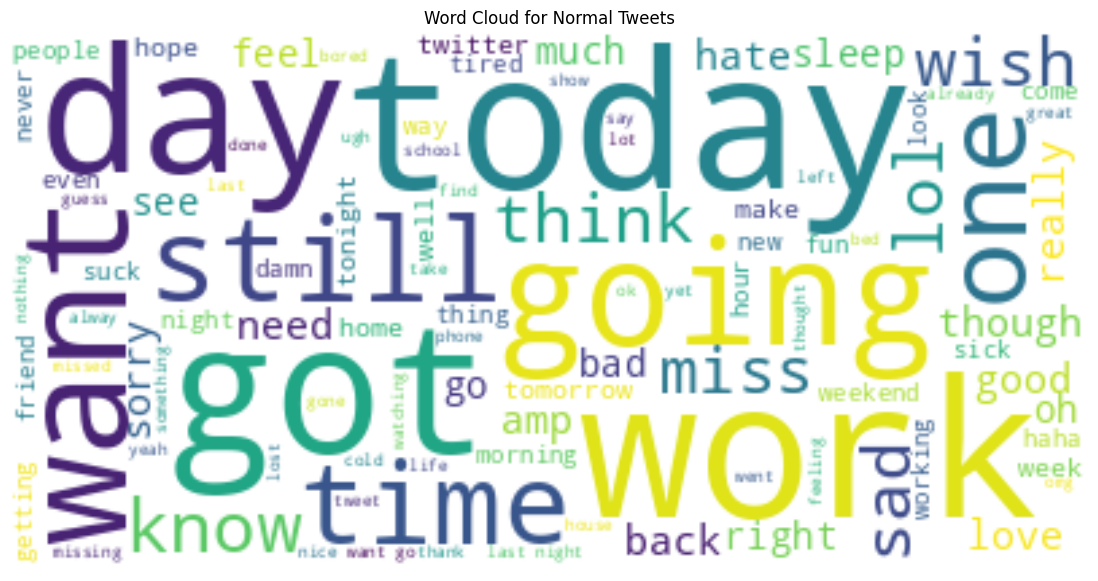

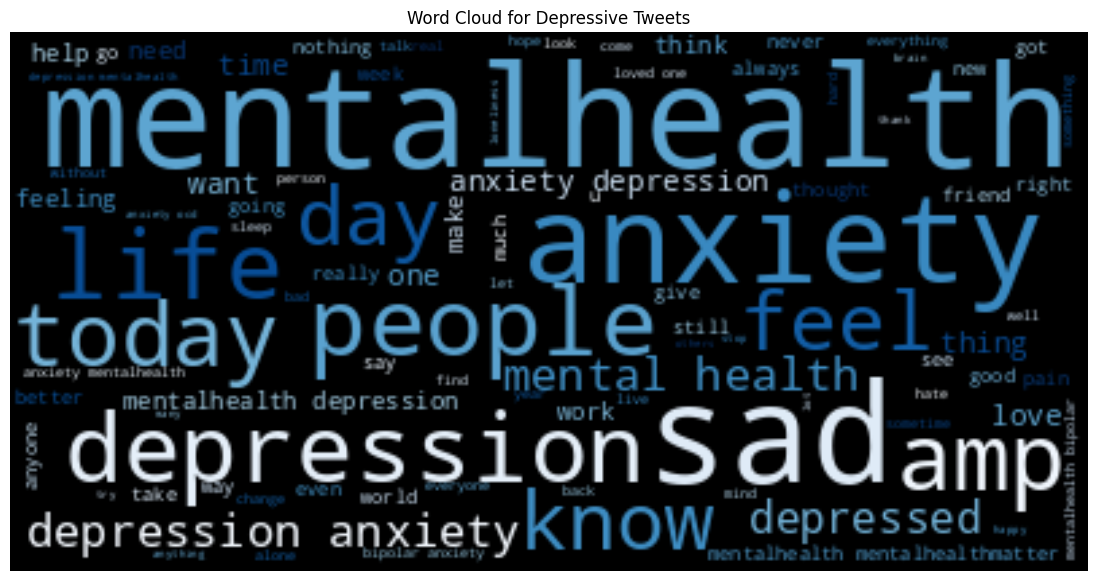

In [87]:
def show_wordcloud(text, title):
    wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.title(title)
    plt.show()

def show_wordclou_depressive(text, title):
    wordcloud = WordCloud(max_words=100, colormap="Blues").generate(text)
    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.title(title)
    plt.show()


normal_tweets = df[df['label'] == 0]['text']
depressive_tweets = df[df['label'] == 1]['text']

normal_text = ' '.join(normal_tweets)
depressive_text = ' '.join(depressive_tweets)

show_wordcloud(normal_text, "Word Cloud for Normal Tweets")
show_wordclou_depressive(depressive_text, "Word Cloud for Depressive Tweets")

In [88]:
normal_words = list(itertools.chain(*[tweet.split() for tweet in normal_tweets]))
depressive_words = list(itertools.chain(*[tweet.split() for tweet in depressive_tweets]))

normal_word_count = Counter(normal_words)
depressive_word_count = Counter(depressive_words)

print("Most common words in normal tweets:")
print(normal_word_count.most_common(10))
print("\nMost common words in depressive tweets:")
print(depressive_word_count.most_common(10))

Most common words in normal tweets:
[('work', 3942), ('go', 3606), ('going', 3511), ('cannot', 3331), ('get', 3320), ('day', 3258), ('want', 2966), ('back', 2960), ('today', 2941), ('like', 2905)]

Most common words in depressive tweets:
[('mentalhealth', 9259), ('anxiety', 8755), ('depression', 8042), ('sad', 4368), ('suicide', 2451), ('like', 2414), ('life', 2132), ('people', 2073), ('depressed', 1991), ('amp', 1978)]


# **Section 3: Feature Extraction**

In [89]:
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
# Split the dataset
train_data, validation_data = train_test_split(df, test_size=0.2, random_state=42)

In [91]:
def calculate_proportions(data):
    len_rows = len(data)
    depressive_rows = len(data[data['label'] == 1])
    non_depressive_rows = len(data[data['label'] == 0])
    
    depressive_percentage = (depressive_rows / len_rows) * 100
    non_depressive_percentage = (non_depressive_rows / len_rows) * 100
    
    return depressive_percentage, non_depressive_percentage

train_depressive_percentage, train_normal_percentage = calculate_proportions(train_data)
validation_depressive_percentage, validation_normal_percentage = calculate_proportions(validation_data)

print(f"Development set: Depressive = {train_depressive_percentage:.2f}%, non-Depressive = {train_normal_percentage:.2f}%")
print(f"Validation set: Depressive = {validation_depressive_percentage:.2f}%, non-Depressive = {validation_normal_percentage:.2f}%")

Development set: Depressive = 28.67%, non-Depressive = 71.33%
Validation set: Depressive = 28.82%, non-Depressive = 71.18%


In [92]:
# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
# Fit the vectorizer to the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [93]:
X_train_tfidf

<67317x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 538304 stored elements in Compressed Sparse Row format>

In [94]:
X_test_tfidf

<16830x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 133187 stored elements in Compressed Sparse Row format>

In [95]:
# save tfidf
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
files.download('/content/tfidf_vectorizer.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Section 4: Model Compare**

When selecting a model for your tweet classification task, it's a good idea to start with simple models and then gradually move to more complex ones if needed.

## **Secion4.1: Logistic Regression**


In [96]:
accuracy_scores = []
recall_scores = []
f1_scores = []

In [97]:
# Train a Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_logreg))
recall_scores.append(recall_score(y_test, y_pred_logreg, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_logreg, average='weighted'))

# Evaluate the Logistic Regression model
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Classification Report:\n", classification_report(y_test, y_pred_logreg, digits=5))

Logistic Regression
Accuracy: 0.9717171717171718
Classification Report:
               precision    recall  f1-score   support

           0    0.97155   0.98923   0.98031     11980
           1    0.97215   0.92845   0.94980      4850

    accuracy                        0.97172     16830
   macro avg    0.97185   0.95884   0.96506     16830
weighted avg    0.97172   0.97172   0.97152     16830



In [98]:
# Save the trained SVM model
joblib.dump(logreg, 'logreg_model.pkl')
files.download('/content/logreg_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Secion4.2: KNN**

In [99]:
# Train a K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_knn))
recall_scores.append(recall_score(y_test, y_pred_knn, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_knn, average='weighted'))

# Evaluate the K-Nearest Neighbors model
print("K-Nearest Neighbors")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn, digits=5))

K-Nearest Neighbors
Accuracy: 0.7359477124183007
Classification Report:
               precision    recall  f1-score   support

           0    0.72956   0.99958   0.84349     11980
           1    0.98798   0.08474   0.15610      4850

    accuracy                        0.73595     16830
   macro avg    0.85877   0.54216   0.49979     16830
weighted avg    0.80403   0.73595   0.64540     16830



## **Secion4.3: Support Vector Classifier**

In [100]:
# Train a Support Vector Machines model
svm = SVC()
svm.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_svm = svm.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_svm))
recall_scores.append(recall_score(y_test, y_pred_svm, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_svm, average='weighted'))

# Evaluate the Support Vector Machines model
print("Support Vector Machines")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm, digits=5))

Support Vector Machines
Accuracy: 0.9816993464052287
Classification Report:
               precision    recall  f1-score   support

           0    0.99050   0.98372   0.98710     11980
           1    0.96046   0.97670   0.96851      4850

    accuracy                        0.98170     16830
   macro avg    0.97548   0.98021   0.97781     16830
weighted avg    0.98185   0.98170   0.98174     16830



In [101]:
# Save the trained SVM model
joblib.dump(svm, 'svm_model.pkl')
files.download('/content/svm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Secion4.4: Random Forests**

In [102]:
# Train a Random Forests model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test_tfidf)

# Save the result
accuracy_scores.append(accuracy_score(y_test, y_pred_rf))
recall_scores.append(recall_score(y_test, y_pred_rf, average='weighted'))
f1_scores.append(f1_score(y_test, y_pred_rf, average='weighted'))

# Evaluate the Random Forests model
print("Random Forests")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf, digits=5))

Random Forests
Accuracy: 0.9822341057635176
Classification Report:
               precision    recall  f1-score   support

           0    0.99067   0.98431   0.98748     11980
           1    0.96184   0.97711   0.96942      4850

    accuracy                        0.98223     16830
   macro avg    0.97626   0.98071   0.97845     16830
weighted avg    0.98237   0.98223   0.98228     16830



In [103]:
# Save the trained rf model
joblib.dump(rf, 'rf_model.pkl')
files.download('/content/rf_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Secion4.5: Compare the basic classification models**

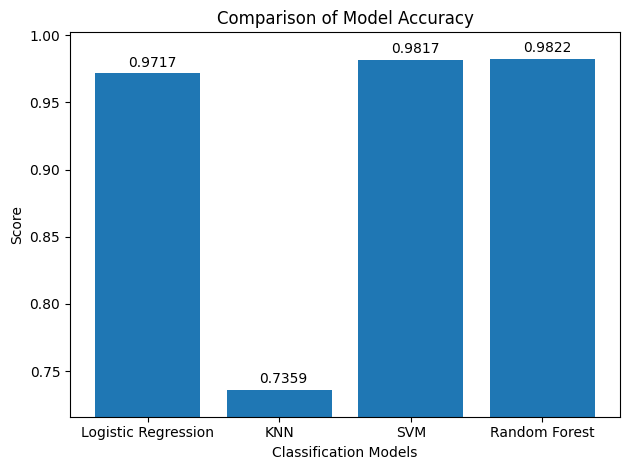

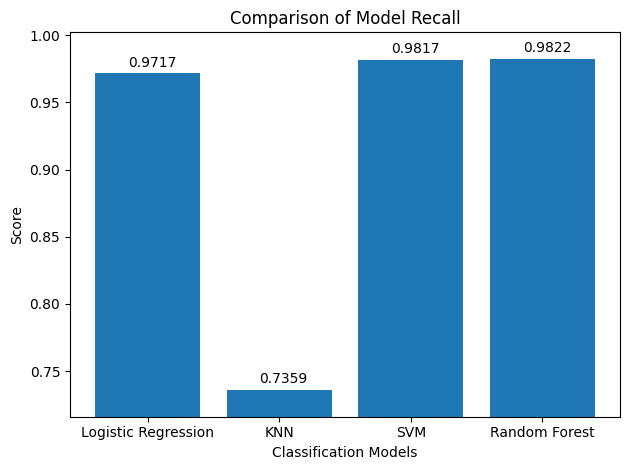

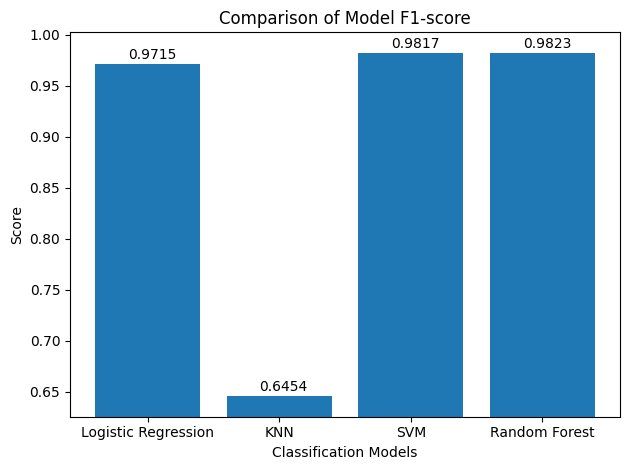

In [107]:
names = ["Logistic Regression", "KNN", "SVM", "Random Forest"]
x = np.arange(len(names))

def plot_metric(metric_name, metric_scores):
    fig, ax = plt.subplots()
    rects = ax.bar(x, metric_scores)
    
    ax.set_xlabel("Classification Models")
    ax.set_ylabel("Score")
    ax.set_title(f"Comparison of Model {metric_name}")
    ax.set_xticks(x)
    ax.set_xticklabels(names)

    # Adjust the y-axis limits for better comparison
    lower_limit = min(metric_scores) - 0.02
    upper_limit = max(metric_scores) + 0.02
    ax.set_ylim(lower_limit, upper_limit)

    # Add the metric value on top of each bar
    for i, v in enumerate(metric_scores):
        ax.text(i - 0.15, v + 0.005, f"{v:.4f}")

    fig.tight_layout()
    plt.show()

# Plot each metric separately
plot_metric("Accuracy", accuracy_scores)
plot_metric("Recall", recall_scores)
plot_metric("F1-score", f1_scores)

## **Secion4.6: Deep Learning Model (LSTM)**



In [108]:
def load_glove_embeddings(file):
    embeddings = {}
    with open(file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_file = 'glove.6B.100d.txt'
glove_embeddings = load_glove_embeddings(glove_file)

In [109]:
max_length = 100  
embedding_dim = 100  

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [110]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

model.fit(X_train_padded, y_train, epochs=5, batch_size=64, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          5555200   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 5,672,577
Trainable params: 117,377
Non-trainable params: 5,555,200
_________________________________________________________________
Epoch 1/5
947/947 [==============================] - 233s 240ms/step - loss: 0.1163 - accuracy: 0.9574 - val_loss: 0.0794 - val_accuracy: 0.9691
Epoch 2/5
947/947 [==============================] - 210s 221ms/step - loss: 0.0765 - accuracy: 0.9724 - val_loss: 0.0657 - val_accuracy: 0.9758
Epoch 3/5
947/

In [111]:
y_pred_lstm_prob = model.predict(X_test_padded)
y_pred_lstm = (y_pred_lstm_prob > 0.5).astype(int).flatten()

print("LSTM")
print("Accuracy:", accuracy_score(y_test, y_pred_lstm))
print("Classification Report:\n", classification_report(y_test, y_pred_lstm, digits=5))

526/526 [==============================] - 15s 27ms/step
LSTM
Accuracy: 0.9771836007130125
Classification Report:
               precision    recall  f1-score   support

           0    0.98068   0.98740   0.98403     11980
           1    0.96833   0.95196   0.96007      4850

    accuracy                        0.97718     16830
   macro avg    0.97451   0.96968   0.97205     16830
weighted avg    0.97712   0.97718   0.97713     16830



In [112]:
joblib.dump(model, 'lstm_model.pkl')
files.download('/content/lstm_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>